<a href="https://colab.research.google.com/github/LukeSchreiber/FastAI-Projects/blob/main/Lesson4Textclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my lesson 4 of fast.ai project.

Text Classifier — CSV Upload Edition

Minimal notebook that lets you **upload a CSV** with `text` and `label` columns, trains a fastai classifier, and evaluates it.



In [2]:
import torch
torch.serialization.add_safe_globals([__import__("fastcore.foundation").foundation.L])


Fixes PyTorch 2.6’s stricter unpickling so fastai objects (like fastcore.L) can load (used by things like lr_find).

In [3]:
from fastai.text.all import *
import pandas as pd, numpy as np, random, torch, fastai

def seed_everything(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
seed_everything(42)

print(f"fastai: {fastai.__version__}")
print("CUDA available:", torch.cuda.is_available())


fastai: 2.8.3
CUDA available: True


imports fastai, torch, numpy and pandas. also sets seed everything to 42

In [4]:


USE_COLAB_UPLOAD = True

if USE_COLAB_UPLOAD:
    try:
        from google.colab import files
        uploaded = files.upload()
        assert uploaded, "No file uploaded."
        csv_fn = list(uploaded.keys())[0]
        print(f"Loaded: {csv_fn}")
        df = pd.read_csv(csv_fn)
    except Exception as e:
        raise RuntimeError(f"Colab upload failed: {e}")
else:
    csv_path = "data.csv"
    print(f"Reading: {csv_path}")
    df = pd.read_csv(csv_path)

print("Rows:", len(df))
display(df.head(3))


Saving text100k.csv to text100k (1).csv
Loaded: text100k (1).csv
Rows: 100000


,text,label
0,@support vibes are immaculate this movie — elite.,pos
1,this goes hard this experience — wonderful.,pos
2,SO GOOD THIS PRODUCT — SUPERB! HIGHLY RECOMMEND,pos


either load up a google colab picker or use a csv

In [5]:


text_candidates  = ['text', 'body', 'content', 'tweet', 'post', 'review', 'sentence']
label_candidates = ['label', 'labels', 'target', 'y', 'sentiment', 'class']

def pick_column(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    raise ValueError(f"None of the columns {candidates} found. Available: {list(df.columns)}")

if 'text' not in df.columns:
    text_col = pick_column(df, text_candidates)
else:
    text_col = 'text'

if 'label' not in df.columns:
    label_col = pick_column(df, label_candidates)
else:
    label_col = 'label'

df = df[[text_col, label_col]].rename(columns={text_col:'text', label_col:'label'}).dropna().reset_index(drop=True)

df['label'] = df['label'].astype(str).str.strip()

print("Using columns -> text:", 'text', "| label:", 'label')
print(df.sample(min(5, len(df))))
print("Label distribution:")
display(df['label'].value_counts())


Using columns -> text: text | label: label
                                               text    label
75721            serviceable ui; baseline quality!!  neutral
80184            serviceable app; baseline quality!  neutral
19864  i enjoy this ui — amazing! five stars #movie      pos
76699           As Described Model; Feels Standard…  neutral
92991            it's okay game for light use?! 🫤 🫤  neutral
Label distribution:


,count
label,
pos,33334
neg,33333
neutral,33333


classify labels. clean data up with pandas. print out info and show the chart of how many of each labels

In [6]:
bs = 128 if torch.cuda.is_available() else 32      #if big boy gpu use 128 batches if not rock with 32
seq_len = 72
EPOCHS = 3
BASE_LR = 1e-3

dls = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=seq_len, min_freq=2), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)  #10% validation
).dataloaders(df, bs=bs, drop_last=False, num_workers=2)

learn = text_classifier_learner(
    dls, AWD_LSTM, pretrained=True, drop_mult=0.6,
    metrics=[accuracy, F1Score(average='macro')],
    loss_func=CrossEntropyLossFlat()  # dataset is balanced; weights not needed
)

if torch.cuda.is_available():
    learn = learn.to_fp16()

learn.fine_tune(EPOCHS, base_lr=BASE_LR, freeze_epochs=1)


/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.299150,0.041455,0.990400,0.990506,00:30


/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.115465,0.002728,0.999800,0.999801,00:29
1,0.030415,0.003921,1.000000,1.000000,00:29
2,0.033768,0.000881,1.000000,1.000000,00:29


Build DataLoaders from df. make a pretrained AWD_LSTM classifier. use fp16 if GPU, then fine-tune 3 epochs at 1e-3 base with 10% validation.


In [7]:
#new concept here
from collections import Counter
counts = Counter([int(y) for _, y in dls.train_ds])   #counts how many training items each class index has.
num_classes = len(dls.vocab[1])  #how many classes total
weights = torch.tensor([1.0 / counts.get(i, 1) for i in range(num_classes)]).float() #creates a weight per class = inverse frequency (rare classes get bigger weight).
#this builds weights for each class so if something rare pops up it doesnt have a crazy weight

learn = text_classifier_learner(
    dls, AWD_LSTM, pretrained=True, drop_mult=0.5,
    metrics=[accuracy, F1Score(average='macro')],
    loss_func=CrossEntropyLossFlat(weight=weights)
).to_fp32()

learn


create a weight balancer as explained in the cell. then create learn

Suggested LR (valley, slide): 0.005248074419796467 0.02290867641568184


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.248546,0.025907,0.996900,0.996928,00:29


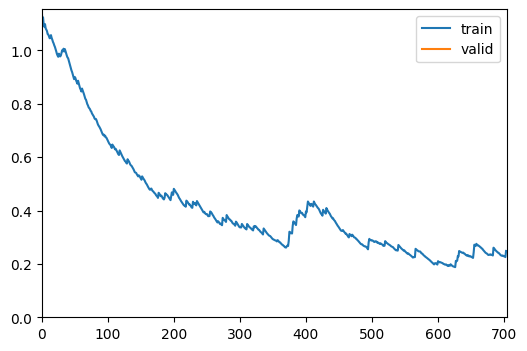

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.073904,0.003453,1.000000,1.000000,00:29
1,0.014830,0.000326,1.000000,1.000000,00:29
2,0.006439,0.001198,1.000000,1.000000,00:29
3,0.002546,0.000057,1.000000,1.000000,00:29
4,0.001880,0.000045,1.000000,1.000000,00:29


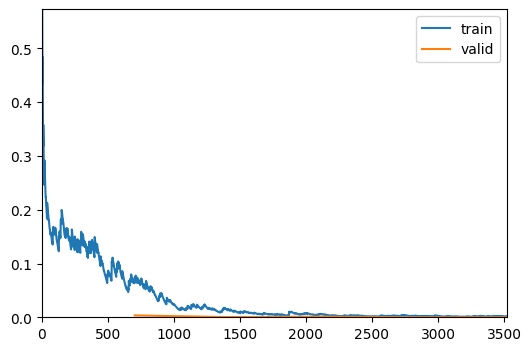

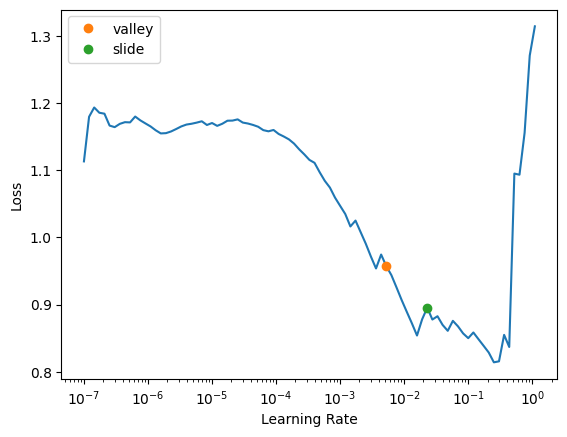

In [8]:

lr_min, lr_steep = learn.lr_find(suggest_funcs=(valley, slide))
print("Suggested LR (valley, slide):", lr_min, lr_steep)

learn.fine_tune(5, base_lr=lr_min/3, freeze_epochs=1, cbs=ShowGraphCallback())


find lr and then train

Validation loss : 0.0000
Validation acc  : 1.0000
Validation F1   : 1.0000


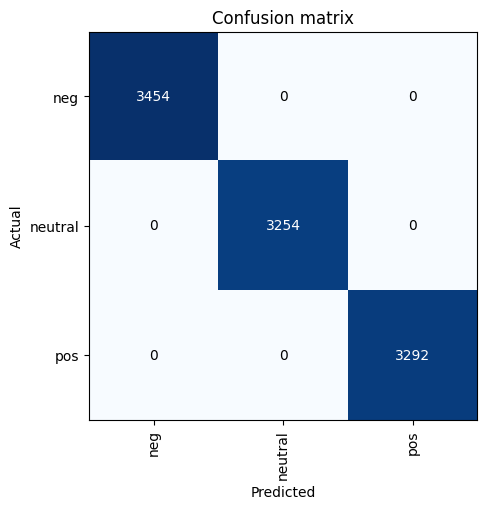

In [9]:
val_loss, acc, f1 = learn.validate()

print(f"Validation loss : {val_loss:.4f}")
print(f"Validation acc  : {acc:.4f}")
print(f"Validation F1   : {f1:.4f}")

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))



evaluate on validation set and make a confusion matrix

In [10]:
def predict_text(text: str):
    pred_class, pred_idx, probs = learn.predict(text)
    return {'text': text, 'pred': str(pred_class), 'probs': {str(c): float(p) for c,p in zip(dls.vocab[1], probs)}}

convenience function for single-text predictions. safe to delete if unused.


In [11]:
learn.export("text_classifier.pkl")
print("Saved model to text_classifier.pkl")


Saved model to text_classifier.pkl


export the model

In [ ]:
import gradio as gr
import torch, re

CLASS_NAMES = list(map(str, dls.vocab[1]))

@torch.no_grad()
def predict_sentiment(text: str):

    text = (text or "").strip()
    if not text:
        raise gr.Error("Please type some text.")

    # require at least 2 word-like tokens
    if len(re.findall(r"\w+", text)) < 2:
        raise gr.Error("Give me a full sentence for a reliable prediction.")

    pred_class, pred_idx, probs = learn.predict(text)

    prob_dict = {cls: float(probs[i]) for i, cls in enumerate(CLASS_NAMES)}
    details = {"prediction": str(pred_class), "confidence": float(probs.max()), "probs": prob_dict}
    return prob_dict, details

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Type a sentence..."),
    outputs=[gr.Label(num_top_classes=len(CLASS_NAMES), label="Prediction"),
             gr.JSON(label="Details")],
    title="📊 Sentiment Classifier",
    description="Type text to get a class + probabilities.",
    allow_flagging="never"
)

demo.launch(share=True, debug=True)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1b181e8dd836282e4e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2250, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1757, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Simple gradio interface